In [1]:
!pip install requests influxdb-client pandas plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 357.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.4/745.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 9.0 MB/s eta 0:00:00


In [12]:
import os
from influxdb_client import InfluxDBClient

# InfluxDB bağlantı detayları
INFLUXDB_TOKEN = "MxddIErEuQSpOYo1QOnIcuYEtJUUAzabDWEHaEeEJNFIA80QYxMzf8fa1Ovs710rkNVE4TCCVj5vs6AwQI_ebA=="
INFLUXDB_ORG = "Data Team"
INFLUXDB_BUCKET = "weatherbucket"

# InfluxDB istemcisini başlatma
client = InfluxDBClient(url="https://us-east-1-1.aws.cloud2.influxdata.com/", token=INFLUXDB_TOKEN)


In [13]:
import requests

# OpenWeatherMap API anahtarı
API_KEY = "afb29bc902762d3e4ec333d0719ac339"

# İstanbul şehrinin hava durumu verilerini çekme
def get_weather_data(city):
    base_url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        "q": city,
        "appid": API_KEY,
        "units": "metric"  # Sıcaklığı Celsius cinsinden almak için
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    if response.status_code == 200:
        return data
    else:
        print(f"Error: {data['message']}")
        return None

# İstanbul şehri için hava durumu verilerini çekme
weather_data = get_weather_data("Istanbul")
print(weather_data)


{'coord': {'lon': 28.9833, 'lat': 41.0351}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'base': 'stations', 'main': {'temp': 25.13, 'feels_like': 25.53, 'temp_min': 25.13, 'temp_max': 25.68, 'pressure': 1011, 'humidity': 70, 'sea_level': 1011, 'grnd_level': 1003}, 'visibility': 10000, 'wind': {'speed': 5.14, 'deg': 40}, 'clouds': {'all': 0}, 'dt': 1724698410, 'sys': {'type': 2, 'id': 2092591, 'country': 'TR', 'sunrise': 1724642708, 'sunset': 1724690816}, 'timezone': 10800, 'id': 745042, 'name': 'Istanbul', 'cod': 200}


In [14]:
def validate_weather_data(data):
    temp = data['main']['temp']
    humidity = data['main']['humidity']
    wind_speed = data['wind']['speed']

    if not (-100 <= temp <= 60):
        print(f"Temperature {temp}°C is out of the valid range!")

    if not (0 <= humidity <= 100):
        print(f"Humidity {humidity}% is out of the valid range!")

    if not (0 <= wind_speed <= 200):
        print(f"Wind speed {wind_speed} km/h is out of the valid range!")

    # Eğer veriler geçerliyse True döndürelim
    return (-100 <= temp <= 60) and (0 <= humidity <= 100) and (0 <= wind_speed <= 200)

# İstanbul hava durumu verilerini doğrulama
is_valid = validate_weather_data(weather_data)
print(f"Is the data valid? {is_valid}")


Is the data valid? True


In [15]:
def clean_weather_data(data):
    # Sıcaklık kontrolü ve dönüşümü (eğer Kelvin ise Celsius'a çevirme)
    if data['main']['temp'] > 100:  # 100°C üstündeki sıcaklıklar Kelvin olabilir
        data['main']['temp'] = data['main']['temp'] - 273.15
        data['main']['feels_like'] = data['main']['feels_like'] - 273.15

    # Rüzgar hızını ve yönünü daha kullanıcı dostu bir formatta birleştirme
    wind_info = f"{data['wind']['speed']} km/h from {data['wind']['deg']}°"

    # Temizlenmiş verileri bir dictionary olarak döndürelim
    cleaned_data = {
        "temperature": data['main']['temp'],
        "feels_like": data['main']['feels_like'],
        "humidity": data['main']['humidity'],
        "wind": wind_info,
        "description": data['weather'][0]['description'],
        "city": data['name'],
        "country": data['sys']['country']
    }

    return cleaned_data

# Veriyi temizleyip düzenleme
cleaned_weather_data = clean_weather_data(weather_data)
print(cleaned_weather_data)


{'temperature': 25.13, 'feels_like': 25.53, 'humidity': 70, 'wind': '5.14 km/h from 40°', 'description': 'clear sky', 'city': 'Istanbul', 'country': 'TR'}


In [16]:
from influxdb_client import Point
from influxdb_client.client.write_api import SYNCHRONOUS
import datetime

# InfluxDB istemcisi ve yazma API'si
write_api = client.write_api(write_options=SYNCHRONOUS)

# Verileri InfluxDB formatında hazırlama
point = Point("weather_data") \
    .tag("location", cleaned_weather_data["city"]) \
    .tag("country", cleaned_weather_data["country"]) \
    .field("temperature", cleaned_weather_data["temperature"]) \
    .field("feels_like", cleaned_weather_data["feels_like"]) \
    .field("humidity", cleaned_weather_data["humidity"]) \
    .field("wind", cleaned_weather_data["wind"].split()[0]) \
    .field("wind_direction", cleaned_weather_data["wind"].split()[-1]) \
    .field("description", cleaned_weather_data["description"]) \
    .time(datetime.datetime.utcnow(), write_precision="s")

# Veriyi InfluxDB'ye yazma
write_api.write(bucket=INFLUXDB_BUCKET, org=INFLUXDB_ORG, record=point)
print("Data written to InfluxDB successfully!")


Data written to InfluxDB successfully!


In [19]:
from influxdb_client import InfluxDBClient
import pandas as pd

# InfluxDB bağlantı detayları
INFLUXDB_TOKEN = "MxddIErEuQSpOYo1QOnIcuYEtJUUAzabDWEHaEeEJNFIA80QYxMzf8fa1Ovs710rkNVE4TCCVj5vs6AwQI_ebA=="
INFLUXDB_ORG = "Data Team"
INFLUXDB_BUCKET = "weatherbucket"

# InfluxDB istemcisini başlatma
client = InfluxDBClient(url="https://us-east-1-1.aws.cloud2.influxdata.com/", token=INFLUXDB_TOKEN)

# Yazma API'si
query_api = client.query_api()

# Basit veri çekme sorgusu
query = f"""
from(bucket: "{INFLUXDB_BUCKET}")
  |> range(start: -1d)
  |> filter(fn: (r) => r["_measurement"] == "weather_data")
"""

# Veriyi çekmek
results = query_api.query(query, org=INFLUXDB_ORG)

# Veriyi manuel olarak işleme
data = []
for table in results:
    for record in table.records:
        data.append({
            "time": record.get_time(),
            "field": record.get_field(),
            "value": record.get_value()
        })

# Pandas DataFrame oluşturma
df = pd.DataFrame(data)
print(df.head())



                       time        field      value
0 2024-08-26 18:59:44+00:00  description  clear sky
1 2024-08-26 18:59:44+00:00   feels_like      25.53
2 2024-08-26 18:59:44+00:00     humidity         70
3 2024-08-26 18:59:44+00:00  temperature      25.13
4 2024-08-26 18:59:44+00:00         wind       5.14


In [20]:
# Veriyi pivot etmek için
df_pivot = df.pivot(index='time', columns='field', values='value')

# Sonuçları görmek için
print(df_pivot.head())


field                            Feels Like Humidity Temperature  \
time                                                               
2024-08-26 18:15:49.296870+00:00       34.5       77       29.15   
2024-08-26 18:59:44+00:00               NaN      NaN         NaN   

field                                       Wind description feels_like  \
time                                                                      
2024-08-26 18:15:49.296870+00:00  5.66 km/s Doğu         NaN        NaN   
2024-08-26 18:59:44+00:00                    NaN   clear sky      25.53   

field                            humidity temperature  wind wind_direction  
time                                                                        
2024-08-26 18:15:49.296870+00:00      NaN         NaN   NaN            NaN  
2024-08-26 18:59:44+00:00              70       25.13  5.14            40°  


In [21]:
# Zaman damgasını datetime formatına dönüştürme (eğer gerekli ise)
df['time'] = pd.to_datetime(df['time'])

# Zaman damgasını kontrol etme
print(df['time'].head())


0   2024-08-26 18:59:44+00:00
1   2024-08-26 18:59:44+00:00
2   2024-08-26 18:59:44+00:00
3   2024-08-26 18:59:44+00:00
4   2024-08-26 18:59:44+00:00
Name: time, dtype: datetime64[ns, tzlocal()]


In [23]:
# NaN değerleri temizleme veya doldurma
df_pivot = df_pivot.fillna(0)


In [25]:
# 'wind' sütununun ilk birkaç değerini kontrol etme
print(df_pivot['wind'].head())


time
2024-08-26 18:15:49.296870+00:00       0
2024-08-26 18:59:44+00:00           5.14
Name: wind, dtype: object


In [26]:
# 'wind' sütununu float türüne dönüştürme
df_pivot['wind'] = pd.to_numeric(df_pivot['wind'], errors='coerce')

# NaN değerleri 0 ile doldurma (veya uygun bir değer ile)
df_pivot['wind'] = df_pivot['wind'].fillna(0)


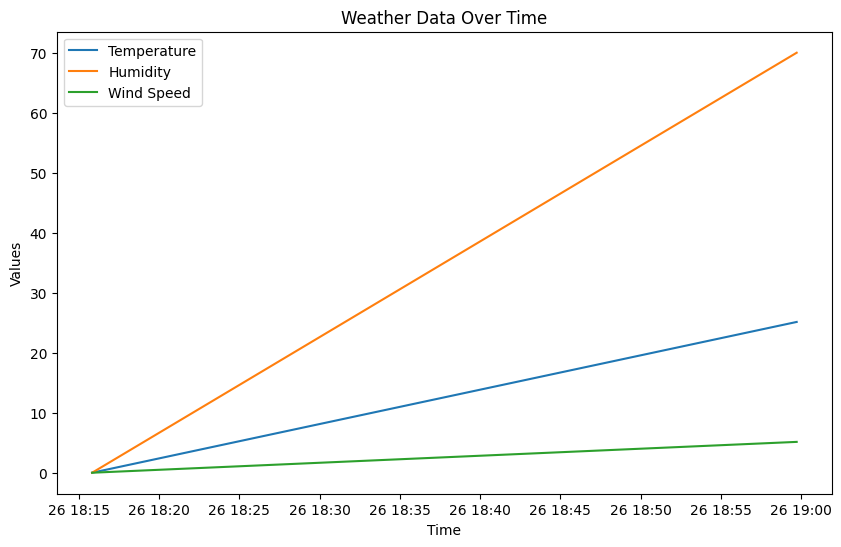

In [27]:
import matplotlib.pyplot as plt

# Grafik oluşturma
plt.figure(figsize=(10, 6))
plt.plot(df_pivot.index, df_pivot['temperature'], label='Temperature')
plt.plot(df_pivot.index, df_pivot['humidity'], label='Humidity')
plt.plot(df_pivot.index, df_pivot['wind'], label='Wind Speed')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Weather Data Over Time')
plt.legend()
plt.show()
